In [108]:
import os
import matplotlib.pyplot  as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
import numpy as np

Load the images in a DataFrame and label them:

The DataFrame consists of 2 columns:

    - Image path

    - Label : fruit_quality

In [68]:
data_dir = "../data/raw/fruit_images"
bad_quality_path = data_dir + "/bad_quality_fruits"
good_quality_path = data_dir + "/good_quality_fruits"
mixed_quality_path = data_dir + "/mixed_quality_fruits"

file_paths=[]
labels=[]
height = 0
width = 0 
samples = 0
sample_count = 20

for fruit_quality in [bad_quality_path, good_quality_path, mixed_quality_path]:
    fruit_list = os.listdir(fruit_quality)
    for fruit in fruit_list:
        fruit_path = os.path.join(fruit_quality, fruit)
        image_list = os.listdir(fruit_path)
        for i, img in enumerate(image_list):
            image_path = os.path.join(fruit_path, img)
            if i < sample_count:
                img = plt.imread(image_path)               
                height += img.shape[0]
                width += img.shape[1]
                samples +=1
            file_paths.append(image_path)
            if fruit_quality == mixed_quality_path:
                labels.append(fruit + '_Mixed')
            else:
                labels.append(fruit)
            
fruit_series = pd.Series(file_paths, name='image')
label_series = pd.Series(labels, name='label')
df = pd.concat([fruit_series, label_series], axis=1)

In [69]:
distinct_labels_df = df.drop_duplicates(subset="label")
# Display the first few rows of the DataFrame for distinct labels
print(distinct_labels_df.head(18))

                                                   image              label
0      ../data/raw/fruit_images/bad_quality_fruits\Ap...          Apple_Bad
1137   ../data/raw/fruit_images/bad_quality_fruits\Ba...         Banana_Bad
2224   ../data/raw/fruit_images/bad_quality_fruits\Gu...          Guava_Bad
3353   ../data/raw/fruit_images/bad_quality_fruits\Li...           Lime_Bad
4438   ../data/raw/fruit_images/bad_quality_fruits\Or...         Orange_Bad
5597   ../data/raw/fruit_images/bad_quality_fruits\Po...    Pomegranate_Bad
6784   ../data/raw/fruit_images/good_quality_fruits\A...         Apple_Good
7933   ../data/raw/fruit_images/good_quality_fruits\B...        Banana_Good
9046   ../data/raw/fruit_images/good_quality_fruits\G...         Guava_Good
10198  ../data/raw/fruit_images/good_quality_fruits\L...          Lime_Good
11292  ../data/raw/fruit_images/good_quality_fruits\O...        Orange_Good
12508  ../data/raw/fruit_images/good_quality_fruits\P...   Pomegranate_Good
18448  ../da

In [70]:
print(f"Average Height: {height/samples}, Average Width: {width/samples}")

Average Height: 226.66666666666666, Average Width: 230.4


The function bellow (df_information) is used to :
    - Count the images in a df.
    - Count the distinct classes (labels) of a df.
    - Print the distinct classes and how many images each class contains.

In [71]:
def df_information(df_: pd.DataFrame):    
    class_count = len(list(df["label"].unique()))
    print(f"The dataset contains {df_.shape[0]} images.")
    print(f"The dataset contains the following {class_count} distinct classes. \n")

    for fruit_class in list(df["label"].unique()):
        print(fruit_class)

    items_per_class = list(df_["label"].value_counts())
    print(f"\nEach of the above classses contains {items_per_class} images.")

In [72]:
df_information(df)

The dataset contains 19522 images.
The dataset contains the following 18 distinct classes. 

Apple_Bad
Banana_Bad
Guava_Bad
Lime_Bad
Orange_Bad
Pomegranate_Bad
Apple_Good
Banana_Good
Guava_Good
Lime_Good
Orange_Good
Pomegranate_Good
Apple_Mixed
Banana_Mixed
Guava_Mixed
Lemon_Mixed
Orange_Mixed
Pomegranate_Mixed

Each of the above classses contains [5940, 1216, 1187, 1159, 1152, 1149, 1137, 1129, 1113, 1094, 1087, 1085, 285, 278, 148, 125, 125, 113] images.


We want to split our initial df in 3 dfs based on their use in the Deep Learning models. For this reason we want a train_df, a test_df and a validation_df.

    - Train_df = 0.7 * initial_df

    - Train_df = 0.15 * initial_df
    
    - Train_df = 0.15 * initial_df

In [73]:
# Split the DataFrame into train (70%), validation (15%), and test (15%)
train_df, test_and_val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_and_val_df, test_size=0.5, random_state=42)

# Check the lengths of the resulting DataFrames
print("Train set length:", len(train_df))
print("Validation set length:", len(val_df))
print("Test set length:", len(test_df))


Train set length: 15617
Validation set length: 1952
Test set length: 1953


We want to trim the train_df to contain a specific number of samples per class.

This way the training will be less biased to a specific class and more generic.

In [74]:
def df_trim(df_: pd.DataFrame, desired_samples_per_class: int) -> pd.DataFrame:

    # Create an empty DataFrame to store the trimmed data
    trimmed_train_df = pd.DataFrame(columns=df_.columns)

    # Iterate through each class and select the first 200 samples
    for class_name in train_df['label'].unique():
        class_samples = train_df[train_df['label'] == class_name].head(desired_samples_per_class)
        trimmed_train_df = pd.concat([trimmed_train_df, class_samples])

    # Reset the index of the trimmed DataFrame
    trimmed_train_df.reset_index(drop=True, inplace=True)

    return trimmed_train_df

We choose to have 200 samples per class!

In [75]:
trimmed_train_df = df_trim(df_= train_df, desired_samples_per_class=200)

df_information(df_= trimmed_train_df)

The dataset contains 3214 images.
The dataset contains the following 18 distinct classes. 

Apple_Bad
Banana_Bad
Guava_Bad
Lime_Bad
Orange_Bad
Pomegranate_Bad
Apple_Good
Banana_Good
Guava_Good
Lime_Good
Orange_Good
Pomegranate_Good
Apple_Mixed
Banana_Mixed
Guava_Mixed
Lemon_Mixed
Orange_Mixed
Pomegranate_Mixed

Each of the above classses contains [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 117, 106, 99, 92] images.


In [76]:
def classes_with_less_than_n_samples(df_: pd.DataFrame, desired_samples_per_class: int):
    class_counts = df_['label'].value_counts()
    classes_with_less_than_n_samples_list =  class_counts[class_counts < desired_samples_per_class].index.tolist()
    print(f"Classes with less than {desired_samples_per_class} samples : {classes_with_less_than_n_samples_list}")

    return classes_with_less_than_n_samples_list

We shall augment as many images as needed in order for all the classes of fruits to have 200 images.

The image augmentation consists of rotating an image and flipping it horizontally with a 0.5 chance.

In [77]:
# Define a data augmentation function
import random

def augment_image(image_path, save_folder):
    os.makedirs(save_folder, exist_ok=True)
    image = Image.open(image_path)
    # Apply random rotation (you can customize the rotation angle)
    angle = np.random.randint(-15, 15)
    augmented_image = image.rotate(angle)

    # Apply horizontal flip with a 50% chance
    if np.random.choice([True, False]):
        augmented_image = ImageOps.mirror(augmented_image)

    if save_folder:
        # Ensure the save folder exists
        os.makedirs(save_folder, exist_ok=True)
        filename = f"AUG_IMG_{np.random.randint(1000)}_{angle}.jpg"
        file_path = os.path.join(save_folder, filename)
        augmented_image.save(file_path)
    
    return file_path


In [78]:
def df_balance(df_: pd.DataFrame, desired_samples_per_class : int) -> pd.DataFrame:
    save_folder = os.path.join(data_dir, "augmented")
    # Iterate through the classes with fewer than 200 samples
    target_class = classes_with_less_than_n_samples(df_=df_, desired_samples_per_class=200)
    for class_name in target_class:
            class_samples = df_[df_["label"]==class_name].value_counts()
            class_df = df_[df_["label"] == class_name]

            images_to_augment = len(class_samples)
            while images_to_augment < desired_samples_per_class:
                
                # Choose an image from the class
                random_index = random.randint(0, len(class_df) - 1)
                # Get the image file path at the random index
                random_image = class_df.iloc[random_index]["image"]

                # Apply data augmentation to generate a new image
                augmented_image = augment_image(image_path=random_image, save_folder=save_folder)

                # Append the augmented image to your dataset
                new_df = pd.DataFrame({'image': [augmented_image], 'label': [class_name]})
                df_ = pd.concat([df_, new_df], ignore_index=True)
                images_to_augment+=1
            print(f"For class [{class_name}] I have augmented [{desired_samples_per_class-len(class_samples)}] images.")
    return df_


In [79]:
df_balanced = df_balance(trimmed_train_df, 200)

Classes with less than 200 samples : ['Guava_Mixed', 'Orange_Mixed', 'Pomegranate_Mixed', 'Apple_Mixed']
For class [Guava_Mixed] I have augmented [83] images.
For class [Orange_Mixed] I have augmented [94] images.
For class [Pomegranate_Mixed] I have augmented [101] images.
For class [Apple_Mixed] I have augmented [108] images.


Now all of our classes in the train_df have 200 samples of images.

This will make the training more balanced.

In [80]:
df_information(df_balanced)

The dataset contains 3600 images.
The dataset contains the following 18 distinct classes. 

Apple_Bad
Banana_Bad
Guava_Bad
Lime_Bad
Orange_Bad
Pomegranate_Bad
Apple_Good
Banana_Good
Guava_Good
Lime_Good
Orange_Good
Pomegranate_Good
Apple_Mixed
Banana_Mixed
Guava_Mixed
Lemon_Mixed
Orange_Mixed
Pomegranate_Mixed

Each of the above classses contains [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200] images.


We want to resize our images to be 224x224.

In [81]:
def resize_image(image_path : os.path, output_path: os.path, new_width : int, new_height: int):
    image = Image.open(image_path)
    resized_image = image.resize((new_width, new_height))
    resized_image.save(output_path)

new_width = 224
new_height = 224

for index, row in df_balanced.iterrows():
    image_path = row["image"]
    print(image_path, index)
    if os.path.exists(image_path):
        resize_image(image_path=image_path, output_path=image_path, new_width=new_width, new_height=new_height)
    else:
        print(f"File not found: {image_path}")

print(df_balanced["image"])

../data/raw/fruit_images/bad_quality_fruits\Lime_Bad\IMG_7422.JPG 0
../data/raw/fruit_images/bad_quality_fruits\Lime_Bad\IMG_7226.JPG 1
../data/raw/fruit_images/bad_quality_fruits\Lime_Bad\IMG_20190820_085648_1.jpg 2
../data/raw/fruit_images/bad_quality_fruits\Lime_Bad\IMG_20190923_183708_1.jpg 3
../data/raw/fruit_images/bad_quality_fruits\Lime_Bad\IMG_7445.JPG 4
../data/raw/fruit_images/bad_quality_fruits\Lime_Bad\IMG_6952.JPG 5
../data/raw/fruit_images/bad_quality_fruits\Lime_Bad\IMG_20190820_085505.jpg 6
../data/raw/fruit_images/bad_quality_fruits\Lime_Bad\IMG_7185.JPG 7
../data/raw/fruit_images/bad_quality_fruits\Lime_Bad\IMG_7221.JPG 8
../data/raw/fruit_images/bad_quality_fruits\Lime_Bad\IMG_20190923_183534.jpg 9
../data/raw/fruit_images/bad_quality_fruits\Lime_Bad\IMG_20190822_075658.jpg 10
../data/raw/fruit_images/bad_quality_fruits\Lime_Bad\IMG_7401.JPG 11
../data/raw/fruit_images/bad_quality_fruits\Lime_Bad\IMG_20190923_183810.jpg 12
../data/raw/fruit_images/bad_quality_fruits

We should add the dimensions of every image in the df

In [84]:
def df_add_dimensions_column(df_:pd.DataFrame)-> pd.DataFrame:
    heights = []
    widths = []

    for image_path in df_["image"]:
        img = Image.open(image_path)
        width, height = img.size
        heights.append(height)
        widths.append(width)

    df_["height"] = heights
    df_["width"] = widths

    return df_

In [86]:
df_balanced = df_add_dimensions_column(df_=df_balanced)
print(df_balanced)


                                                  image        label  height  \
0     ../data/raw/fruit_images/bad_quality_fruits\Li...     Lime_Bad     224   
1     ../data/raw/fruit_images/bad_quality_fruits\Li...     Lime_Bad     224   
2     ../data/raw/fruit_images/bad_quality_fruits\Li...     Lime_Bad     224   
3     ../data/raw/fruit_images/bad_quality_fruits\Li...     Lime_Bad     224   
4     ../data/raw/fruit_images/bad_quality_fruits\Li...     Lime_Bad     224   
...                                                 ...          ...     ...   
3595  ../data/raw/fruit_images\augmented\AUG_IMG_443...  Apple_Mixed     224   
3596  ../data/raw/fruit_images\augmented\AUG_IMG_437...  Apple_Mixed     224   
3597  ../data/raw/fruit_images\augmented\AUG_IMG_755...  Apple_Mixed     224   
3598  ../data/raw/fruit_images\augmented\AUG_IMG_379...  Apple_Mixed     224   
3599  ../data/raw/fruit_images\augmented\AUG_IMG_687...  Apple_Mixed     224   

      width  
0       224  
1       224

We showcase one image per class

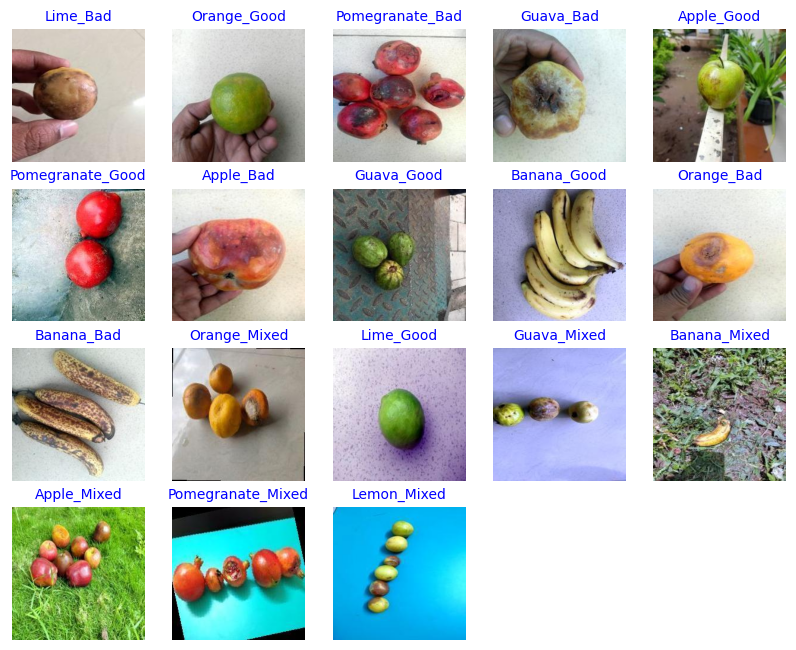

In [106]:
distinct_labels = df_balanced["label"].unique()

# Set the number of images to display for each label
num_images_per_label = 1

# Create a figure to display the images
plt.figure(figsize=(10, 10))
for label in distinct_labels:
    # Get all images for the current label
    label_df = df_balanced[df_balanced["label"] == label]
    
    random_index = random.randint(0, len(label_df) - 1)
    
    sample_image = label_df.iloc[random_index]["image"]

    # Load and display the image
    img = plt.imread(sample_image)
    plt.subplot(5, 5, distinct_labels.tolist().index(label) + 1)
    plt.imshow(img)
    plt.title(label, color='blue', fontsize=10)
    plt.axis("off")

plt.show()